In [2]:
import stackstac
import pystac_client
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

In [3]:
#leeds lon lat
# lon, lat = -1.550, 53.800
#edinburgh lon lat
lon, lat = -3.3217, 55.882

In [5]:
%%time
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-2-l2a"],
    datetime="2023-06-01/2023-06-30"
).item_collection()
len(items)

CPU times: user 59.9 ms, sys: 3.08 ms, total: 63 ms
Wall time: 3.1 s


24

In [6]:
%time stack = stackstac.stack(items)

CPU times: user 47.9 ms, sys: 11.1 ms, total: 59 ms
Wall time: 60.2 ms


In [7]:
stack

<xarray.DataArray 'stackstac-6eed04a12d1ab42d21bfb6ef8f6667f4' (time: 24,
                                                                band: 32,
                                                                y: 20976,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(24, 32, 20976, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2023-06-01...
    id                                       (time) <U24 'S2B_30VVH_20230601_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 4e+05 ... 5.098e+05
  * y                                        (y) float64 6.3e+06 ... 6.09e+06
    constellation                            <U10 'sentinel-2'
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(399960.0, 6090240.0, 509760.0...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6300000.00|\n| 0.0...
    resolution:  10.0

In [8]:
lowcloud = stack[stack["eo:cloud_cover"] < 30]
rgb = lowcloud.sel(band=["red", "green", "blue"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)
monthly

<xarray.DataArray 'stackstac-6eed04a12d1ab42d21bfb6ef8f6667f4' (time: 1,
                                                                band: 3,
                                                                y: 20976,
                                                                x: 10980)>
dask.array<stack, shape=(1, 3, 20976, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 4e+05 ... 5.098e+05
  * y                                        (y) float64 6.3e+06 ... 6.09e+06
    constellation                            <U10 'sentinel-2'
    s2:sequence                              <U1 '0'
    s2:saturated_defective_pixel_percentage  int64 0
    ...                                       ...
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32630
  * time                                     (time) datetime64[ns] 2023-06-01
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(399960.0, 6090240.0, 509760.0...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6300000.00|\n| 0.0...
    resolution:  10.0

In [9]:
import pyproj
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 10000 #25000  # metres

In [10]:
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-6eed04a12d1ab42d21bfb6ef8f6667f4' (time: 1,
                                                                band: 3,
                                                                y: 2000, x: 2000)>
dask.array<getitem, shape=(1, 3, 2000, 2000), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 4.699e+05 ... 4.899e+05
  * y                                        (y) float64 6.203e+06 ... 6.183e+06
    constellation                            <U10 'sentinel-2'
    s2:sequence                              <U1 '0'
    s2:saturated_defective_pixel_percentage  int64 0
    ...                                       ...
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32630
  * time                                     (time) datetime64[ns] 2023-06-01
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(399960.0, 6090240.0, 509760.0...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6300000.00|\n| 0.0...
    resolution:  10.0

In [11]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[######################                  ] | 57% Completed | 9.59 sms

/home/eesjb/anaconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[########################################] | 100% Completed | 15.28 s


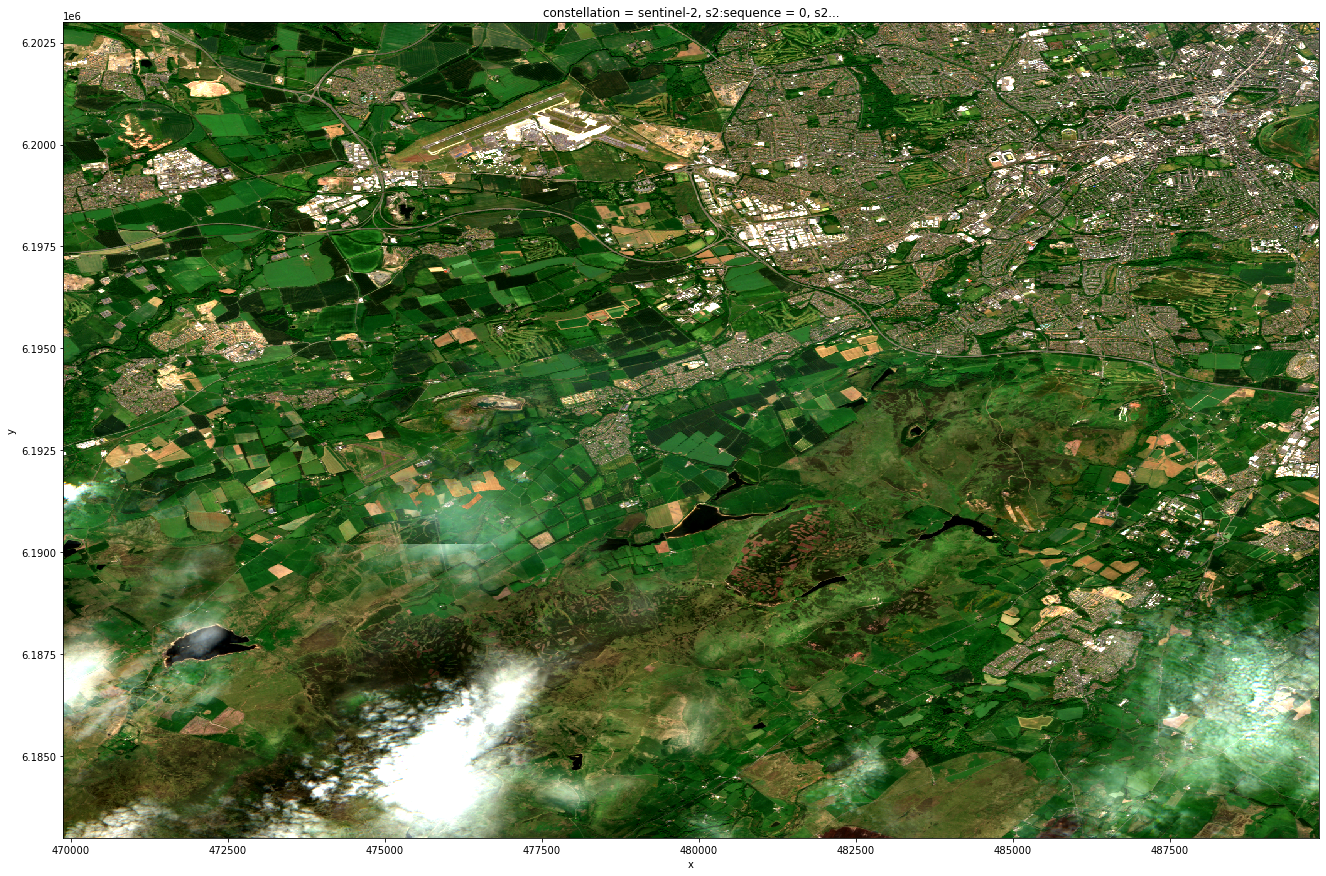

In [12]:
data.isel(time=0).plot.imshow(robust=True, size=15)

In [ ]:
#randomly sample 1000 64x64 pixel images and save as tif to disk
data=monthly
import numpy as np
import rioxarray
from tqdm import tqdm
import os

# Randomly sample 1000 64x64 pixel images
month = data.time.dt.month.values[0].astype(int)
np.random.seed(month)
size = 64
n_samples = 1000
xs = np.random.randint(0, data.sizes["x"] - size, n_samples)
ys = np.random.randint(0, data.sizes["y"] - size, n_samples)

location = "leeds"
filepath = f"sense_ae_data/{location}"
for x,y in tqdm(zip(xs, ys)):
    filename = os.path.join(filepath,f"image_{location}_{month}_{x}_{y}.tif"
    if not os.path.exists(filename)):
        data.isel(x=slice(x, x + size), y=slice(y, y + size)).squeeze().rio.to_raster(filename)